In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

sns.set_palette('deep')
sns.set()

# Get data and remove duplicates

In [250]:
def get_data(files):
    frames = [pd.read_csv(file, sep='\t', index_col=0) for file in files]
    print('Total no. of datasets:', len(frames))
    for index, frame in enumerate(frames):
        print(f'Dataset {index+1} size: {frame.shape}')
    return frames

def clean_data(df): # remove null and duplicates
    null_values = df.isnull().sum()
    print(f'\n\nComplete dataset size: {df.shape}\n\n')
    print('No data:', null_values)

    df = df.dropna(subset=['urlDrugName', 'condition', 'benefitsReview', 
                           'sideEffectsReview', 'commentsReview']) 
    df_duplicates = df[df.duplicated(keep=False)]
    print('No. of duplicates:', len(df_duplicates))
    df = df.drop_duplicates(keep='first')
    print('**Null data and duplicates removed**')
    return df

def describe_dataset(df):  
    print(f'Column names: \n{list(df.columns)}\n\n'
          + f'Type of data for each column: \n{df.dtypes}\n\n No. of empty cells:\n'
          + f'New dataset size: {df.shape}\n\n')
    print(f'Unique values: \n{df.nunique()}')

# def data_full():
frames = get_data(['data/drugLibTest_raw.tsv', 'data/drugLibTrain_raw.tsv'])
df_o = pd.concat(frames)
df_o = clean_data(df_o)
describe_dataset(df_o)
#return df_o

def describe_columns(df):
    score_columns = ['rating', 'effectiveness', 'sideEffects',]
    print('Unique values')
    for col in score_columns:
        print(col)
        print((df[col].unique()))
describe_columns(df_o) 

Total no. of datasets: 2
Dataset 1 size: (1036, 8)
Dataset 2 size: (3107, 8)


Complete dataset size: (4143, 8)


No data: urlDrugName          0
rating               0
effectiveness        0
sideEffects          0
condition            1
benefitsReview       0
sideEffectsReview    2
commentsReview       8
dtype: int64
No. of duplicates: 96
**Null data and duplicates removed**
Column names: 
['urlDrugName', 'rating', 'effectiveness', 'sideEffects', 'condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview']

Type of data for each column: 
urlDrugName          object
rating                int64
effectiveness        object
sideEffects          object
condition            object
benefitsReview       object
sideEffectsReview    object
commentsReview       object
dtype: object

 No. of empty cells:
New dataset size: (4082, 8)


Unique values: 
urlDrugName           540
rating                 10
effectiveness           5
sideEffects             5
condition            1804
benefitsRe

#### replace scales in text to numerical (1-5) 

In [251]:
def replace_scales(df1):
    df2 = df1.copy()
    df2['effectiveness'] = df2['effectiveness'].replace({
        'Highly Effective': 5, 
        'Considerably Effective': 4,
        'Moderately Effective': 3,
        'Marginally Effective': 2,
        'Ineffective': 1})
    df2['sideEffects'] = df2['sideEffects'].replace({
        'No Side Effects': 1,
        'Mild Side Effects': 2,
        'Moderate Side Effects': 3,
        'Severe Side Effects': 4,
        'Extremely Severe Side Effects': 5})
    return df2
    
df_num = replace_scales(df_o)

#### create frequency of rating, effectveness and sideEffects (raw)

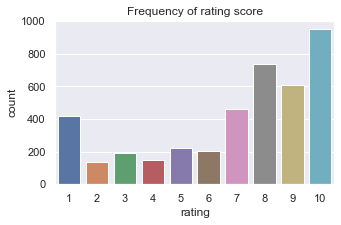

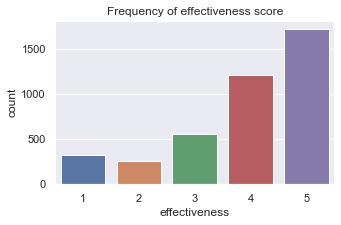

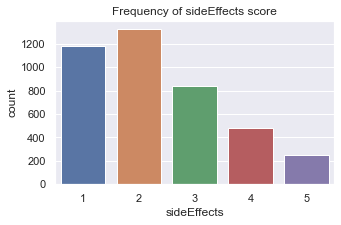

In [252]:
def create_frequency(df, column_name):          #rating, effectiveness, sideeffects
    fig = plt.figure(figsize=(5,3)) 
    sns.countplot(x=df[column_name], data=df).set(title=f'Frequency of {column_name} score')
    plt.show()

create_frequency(df_num, 'rating')
create_frequency(df_num, 'effectiveness')
create_frequency(df_num, 'sideEffects')
    


## Aggregate by drug and condition

In [253]:
def get_group_stats(df, column_name):
    print('Group by:', column_name)
    df_col_info = df.groupby(column_name).agg({'urlDrugName': ['count'],
                                                'rating': ['mean', 'median'],
                                                'effectiveness': ['mean', 'median'],
                                                'sideEffects': ['mean', 'median']})
    df_col_info = df_col_info.sort_values(by=[('urlDrugName', 'count')], ascending=False)
    print('Most common in group:', df_col_info.head())
    return df_col_info   

df_drugs = get_group_stats(df_num, 'urlDrugName')
df_condition = get_group_stats(df_num, 'condition')
print(df_drugs)

Group by: urlDrugName
Most common in group:             urlDrugName    rating        effectiveness        sideEffects  \
                  count      mean median          mean median        mean   
urlDrugName                                                                 
lexapro              71  6.887324    8.0      3.774648    4.0    2.394366   
paxil                58  6.431034    7.0      3.810345    4.0    2.810345   
synthroid            52  7.826923    8.5      3.903846    4.0    1.461538   
retin-a              52  7.673077    8.0      3.769231    4.0    2.346154   
zoloft               52  7.557692    8.0      4.000000    4.0    2.057692   

                    
            median  
urlDrugName         
lexapro        2.0  
paxil          3.0  
synthroid      1.0  
retin-a        2.0  
zoloft         2.0  
Group by: condition
Most common in group:               urlDrugName    rating        effectiveness        sideEffects  \
                    count      mean median        

#### plot

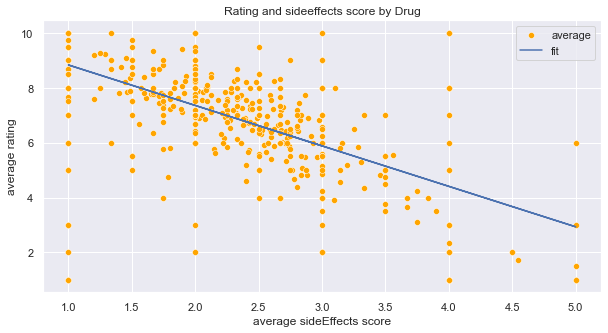

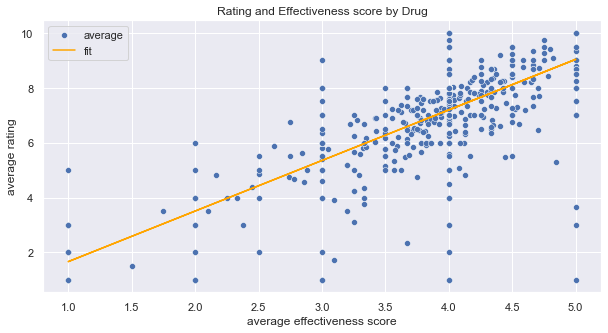

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


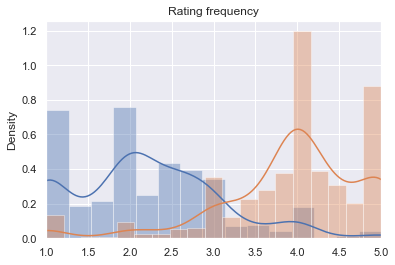

In [254]:
def create_hist(df, column_name):          #rating, effectiveness, sideeffects
    fig = plt.figure(figsize=[10,5])
    ax1 = sns.scatterplot(x=df_drugs[('sideEffects', 'mean')], y=df_drugs[('rating', 'mean')], color='orange').set(title='Rating and sideeffects score by Drug', xlabel='average sideEffects score', ylabel='average rating')
    m1, b1 = np.polyfit(x=df_drugs[('sideEffects', 'mean')], y=df_drugs[('rating', 'mean')], deg=1)
    plt.plot(df_drugs[('sideEffects', 'mean')], df_drugs[('sideEffects', 'mean')]*m1+b1) # plot line
    plt.legend(['average', 'fit'])
    plt.show()
    fig = plt.figure(figsize=[10,5])
    ax2 = sns.scatterplot(x=df_drugs[('effectiveness', 'mean')], y=df_drugs[('rating', 'mean')]).set(title='Rating and Effectiveness score by Drug', xlabel='average effectiveness score', ylabel='average rating')
    m2, b2 = np.polyfit(x=df_drugs[('effectiveness', 'mean')], y=df_drugs[('rating', 'mean')], deg=1)
    plt.plot(df_drugs[('effectiveness', 'mean')], df_drugs[('effectiveness', 'mean')]*m2+b2, color='orange')
    plt.legend(['average', 'fit'])
    plt.show()

    sns.distplot(x=df_drugs[('sideEffects', 'mean')]).set(title='Rating frequency')
    sns.distplot(x=df_drugs[('effectiveness', 'mean')]).set(title='Rating frequency')
    plt.xlim([1,5])

create_hist(df_drugs, 'urlDrugName')

In [255]:
"""df_melt = df.melt(id_vars=['urlDrugName'], value_vars=['effectiveness', 'sideEffects', 'rating'], var_name='type', value_name='score')
sns.boxplot(x='effectiveness', y='rating', data=df, color='blue')
sns.boxplot(x='sideEffects', y='rating', data=df, color='red')

#df_pivot_table = df_melt.pivot_table(columns=['score'], values=['score'])

#sns.countplot(df.sideEffects, legend='side effects', color='pink')
plt.legend()
plt.show()
#df_pivot_table.head()

df_crosstab = pd.crosstab(df['rating'], df['effectiveness'])
df_crosstab['scale'] = 'effectiveness'
df_crosstab = df_crosstab.rename_axis(None, axis=1).rename_axis('rating', axis=0)
df_crosstab.head()
df_crosstab2 = pd.crosstab(df['rating'], df['sideEffects'])
df_crosstab2['scale'] = 'sideEffects'
df_crosstab2 = df_crosstab2.rename_axis(None, axis=1).rename_axis('rating', axis=0)
df_crosstab_scale = pd.concat([df_crosstab, df_crosstab2], ignore_index=False)
df_crosstab_scale.head()
df_crosstab.head()
df_crosstab2.head()
df_crosstab_scale = df_crosstab_scale.reset_index()
df_crosstab_scale"""

"df_melt = df.melt(id_vars=['urlDrugName'], value_vars=['effectiveness', 'sideEffects', 'rating'], var_name='type', value_name='score')\nsns.boxplot(x='effectiveness', y='rating', data=df, color='blue')\nsns.boxplot(x='sideEffects', y='rating', data=df, color='red')\n\n#df_pivot_table = df_melt.pivot_table(columns=['score'], values=['score'])\n\n#sns.countplot(df.sideEffects, legend='side effects', color='pink')\nplt.legend()\nplt.show()\n#df_pivot_table.head()\n\ndf_crosstab = pd.crosstab(df['rating'], df['effectiveness'])\ndf_crosstab['scale'] = 'effectiveness'\ndf_crosstab = df_crosstab.rename_axis(None, axis=1).rename_axis('rating', axis=0)\ndf_crosstab.head()\ndf_crosstab2 = pd.crosstab(df['rating'], df['sideEffects'])\ndf_crosstab2['scale'] = 'sideEffects'\ndf_crosstab2 = df_crosstab2.rename_axis(None, axis=1).rename_axis('rating', axis=0)\ndf_crosstab_scale = pd.concat([df_crosstab, df_crosstab2], ignore_index=False)\ndf_crosstab_scale.head()\ndf_crosstab.head()\ndf_crosstab2.he

#### common drugs

In [256]:
def get_few_drugs_list(df):
    df_few_drugs = df[df[('urlDrugName','count')] < 10]
    print('Total drugs less than 10:', len(df_few_drugs))
    few_drugs = df_few_drugs.index.to_list()
    return few_drugs

def remove_few_drugs(df, few_drugs):
    df_less_drugs = df_num[df_num.urlDrugName.isin(few_drugs) == False]
    print('Drugs more than 10:', len(df_less_drugs))
    return df_less_drugs

few_drugs_list = get_few_drugs_list(df_drugs)
df_many_drugs = remove_few_drugs(df_num, few_drugs_list)

Total drugs less than 10: 406
Drugs more than 10: 2964


In [257]:
def get_common_drugs(df):
    most_common = df.sort_values([('urlDrugName', 'count')], ascending=False)
    most_common = most_common.head(5).index.tolist()                #tuple or dic for counts
    return most_common

most_common_drugs = get_common_drugs(df_drugs)
print(most_common_drugs)

['lexapro', 'paxil', 'synthroid', 'zoloft', 'retin-a']


In [301]:
df_top_drugs = df_num[df_num['urlDrugName'].isin(most_common_drugs)]
df_top_effectiveness = df_top_drugs.groupby(['urlDrugName', 'effectiveness']).count()
df_top_effectiveness = df_top_effectiveness.reset_index()
df_top_effectiveness = df_top_effectiveness.pivot(index='urlDrugName', columns='effectiveness')
df_top_effectiveness = df_top_effectiveness['rating']
df_top_effectiveness = df_top_effectiveness.reset_index()
df_top_effectiveness.head()


effectiveness,urlDrugName,1,2,3,4,5
0,lexapro,5,3,14,30,19
1,paxil,6,3,7,22,20
2,retin-a,2,4,12,20,14
3,synthroid,3,4,10,13,22
4,zoloft,3,1,10,17,21


In [308]:
df_top_effectiveness['sum'] = df_top_effectiveness.sum(axis=1)
for i in range(1,6):
    df_top_effectiveness[i] = df_top_effectiveness[i]/df_top_effectiveness['sum']*100
df_top_effectiveness.head()


effectiveness,urlDrugName,1,2,3,4,5,sum
0,lexapro,4.118277,2.470966,11.531175,24.709661,15.649452,171.0
1,paxil,6.547359,3.273680,7.638586,24.006984,21.824531,158.0
2,retin-a,2.530364,5.060729,15.182186,25.303644,17.712551,152.0
3,synthroid,3.795547,5.060729,12.651822,16.447368,27.834008,152.0
4,zoloft,3.795547,1.265182,12.651822,21.508097,26.568826,152.0


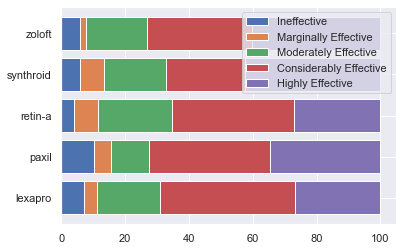

In [306]:
y1, y2, y3, y4, y5 = (df_top_effectiveness[1], df_top_effectiveness[2], df_top_effectiveness[3], df_top_effectiveness[4], df_top_effectiveness[5])
plt.barh(df_top_effectiveness['urlDrugName'], y1)
plt.barh(df_top_effectiveness['urlDrugName'], y2, left=y1)
plt.barh(df_top_effectiveness['urlDrugName'], y3, left=y1+y2)
plt.barh(df_top_effectiveness['urlDrugName'], y4, left=y1+y2+y3)
plt.barh(df_top_effectiveness['urlDrugName'], y5, left=y1+y2+y3+y4)
plt.legend(['Ineffective', 'Marginally Effective', 'Moderately Effective', 'Considerably Effective', 'Highly Effective'], )
plt.show()

In [318]:
df_top_drugs = df_num[df_num['urlDrugName'].isin(most_common_drugs)]
df_top_sideEffects = df_top_drugs.groupby(['urlDrugName', 'sideEffects']).count()
df_top_sideEffects = df_top_sideEffects.reset_index()
df_top_sideEffects = df_top_sideEffects.pivot(index='urlDrugName', columns='sideEffects')
df_top_sideEffects = df_top_sideEffects['rating']
df_top_sideEffects = df_top_sideEffects.reset_index()
df_top_sideEffects = df_top_sideEffects.fillna(0)
df_top_sideEffects.head()

sideEffects,urlDrugName,1,2,3,4,5
0,lexapro,16.0,29.0,13.0,8.0,5.0
1,paxil,8.0,17.0,16.0,12.0,5.0
2,retin-a,6.0,26.0,16.0,4.0,0.0
3,synthroid,36.0,11.0,3.0,1.0,1.0
4,zoloft,16.0,24.0,7.0,3.0,2.0


In [319]:
df_top_sideEffects['sum'] = df_top_sideEffects.sum(axis=1)
for i in range(1,6):
    df_top_sideEffects[i] = df_top_sideEffects[i]/df_top_sideEffects['sum']*100
df_top_sideEffects = df_top_sideEffects.fillna(0)
df_top_sideEffects.head()

sideEffects,urlDrugName,1,2,3,4,5,sum
0,lexapro,22.535211,40.845070,18.309859,11.267606,7.042254,71.0
1,paxil,13.793103,29.310345,27.586207,20.689655,8.620690,58.0
2,retin-a,11.538462,50.000000,30.769231,7.692308,0.000000,52.0
3,synthroid,69.230769,21.153846,5.769231,1.923077,1.923077,52.0
4,zoloft,30.769231,46.153846,13.461538,5.769231,3.846154,52.0


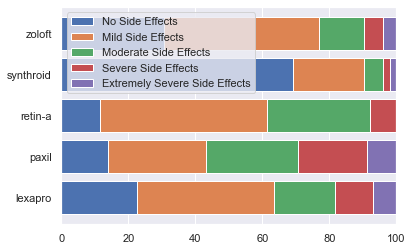

In [320]:
y1, y2, y3, y4, y5 = (df_top_sideEffects[1], df_top_sideEffects[2], df_top_sideEffects[3], df_top_sideEffects[4], df_top_sideEffects[5])
plt.barh(df_top_sideEffects['urlDrugName'], y1)
plt.barh(df_top_sideEffects['urlDrugName'], y2, left=y1)
plt.barh(df_top_sideEffects['urlDrugName'], y3, left=y1+y2)
plt.barh(df_top_sideEffects['urlDrugName'], y4, left=y1+y2+y3)
plt.barh(df_top_sideEffects['urlDrugName'], y5, left=y1+y2+y3+y4)
plt.legend(['No Side Effects','Mild Side Effects','Moderate Side Effects','Severe Side Effects','Extremely Severe Side Effects'])
plt.show()

# Correlation

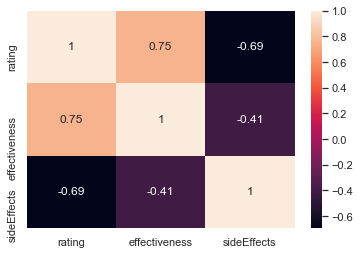

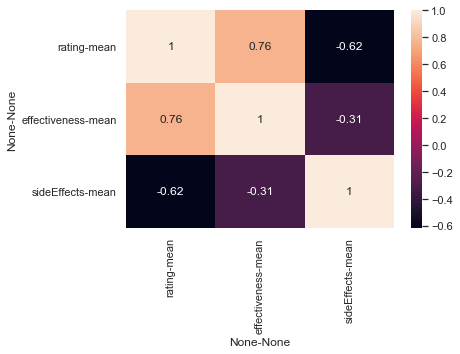

In [258]:
def correlation_raw(df):
    df_corr = df[['rating','effectiveness', 'sideEffects']]
    return df_corr.corr()

def correlation_drugs(df):
    df_corr = df[[('rating', 'mean'), ('effectiveness', 'mean'), ('sideEffects', 'mean')]]
    return df_corr.corr()

def create_correlation_charts(df_corr):
    sns.heatmap(df_corr, annot=True)
    plt.show()

df_corr_o = correlation_raw(df_num)
create_correlation_charts(df_corr_o)

df_corr_drugs = correlation_drugs(df_drugs)
create_correlation_charts(df_corr_drugs)

In [259]:
from scipy.stats import spearmanr

def check_prob(p):
	alpha = 0.05
	if p > alpha:
		print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
	else:
		print('Samples are correlated (reject H0) p=%.3f' % p)

def get_spearman(df):
	print('rating vs effectiveness')
	coef, p = spearmanr(df.rating, df.effectiveness)
	print('Spearmans correlation coefficient: %.3f' % coef)
	check_prob(p)
	print('rating vs sideEffects')
	coef, p = spearmanr(df.rating, df.sideEffects)
	print('Spearmans correlation coefficient: %.3f' % coef)
	check_prob(p)
	print('effectiveness vs sideEffects')
	coef, p = spearmanr(df.effectiveness, df.sideEffects)
	print('Spearmans correlation coefficient: %.3f' % coef)
	check_prob(p)

get_spearman(df_num)


rating vs effectiveness
Spearmans correlation coefficient: 0.724
Samples are correlated (reject H0) p=0.000
rating vs sideEffects
Spearmans correlation coefficient: -0.649
Samples are correlated (reject H0) p=0.000
effectiveness vs sideEffects
Spearmans correlation coefficient: -0.357
Samples are correlated (reject H0) p=0.000


In [260]:
%store df_num
%store df_o

Stored 'df_num' (DataFrame)
Stored 'df_o' (DataFrame)
